# Indonesian Fake News Headline Topic Modeling w/ LDA (Latent Dirichlet Allocation) <a class="anchor" name="chapter0"></a>

### Table of Contents
* [Introduction](#chapter1)
* [Conclusion / Result](#chapter2)
* [Data Preparation](#chapter3)
* [Preprocessing & Visualization](#chapter4)
* [Modeling & Evaluation](#chapter5)

### Introduction / Motivation <a class="anchor" name="chapter1"></a>
Internet is a place used by almost all citizens in the world to search news articles, including Indonesian citizens. Because of the ease of accessing the internet, it is often used as a place to spread fake news. Those fake news has titles that can deceive people to read it (clickbait) by writing about hot topics or famous figures such as religion issues or figures like president. Based on these titles, this notebook will conduct topic modeling to see which topics are often made into fake news.

### About the data
This project used scraped data from [TurnBackHoax.id](https://turnbackhoax.id/) using BeatifulSoup by running `news.py`. TurnBackHoax.ID is a site managed by the Indonesian anti-hoax forum (MAFINDO). Data was collected from July 31, 2015 to June 26, 2022 with a total of about 9 thousand data and 2 columns (`title` and `label`).

### Goal
Goal of this project is to see which topics that are often made into fake news using LDA model. The model will produce a different number of topics and then will be evaluated using coherence score.

### Why use coherence score?
Coherence score can be used to measure how interpretable the topics are to humans. The topics are represented as the top N words with the highest probability that those words are related to that particular topic. However, there will be also analysis for several topics generated by model based on human judgement.

### Conclusion / Result <a class="anchor" id="chapter2"></a>
LDA model was able to be fitted with two different corpus, Bag of Words corpus and TF-IDF corpus. LDA + BoW model produces a coherence score of 0.5892426701862281 with total 16 topics. While LDA + TF-IDF model produces higher coherence score of 0.606701113790169 with less topics, which is 12 topics in total. The result of the two model are presented below in the form of a table:

|Model|Coherence Score|Number of Topics|
|---|---|:---:|
|LDA + BoW|0.5892426701862281|16|
|LDA + TF-IDF|0.606701113790169|12|

By looking at table above, based on the coherence score it is shown that **LDA+TF-IDF** fits better than LDA + BoW model. However, after manualy analyzing both results, LDA + BoW model have better distribution of topics because there are fewer overlapping topics ([here](#bow)). As for LDA+TF-IDF model, only two topics that are not overlapping each other while 10 topics are overlapping ([here](#tfidf)). Generally, by looking at most dominant document for each topics, both model can cluster fake news headline into several topics.


[Back to Table of Contents](#chapter0)

# Data Preparation <a class="anchor" name="chapter3"></a>

Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/headline_data.csv")
df.head(5)

,title,label
0,Anies Baswedan Menandatangani Kontrak untuk P...,SALAH
1,Orang Cina SIAP Perang dengan Pribumi dengan ...,SALAH
2,China Meluncurkan Matahari Buatan,SALAH
3,Anies Baswedan di Cover Majalah Al Islam Wuju...,SALAH
4,Foto Jokowi Memangku Wanita Berbikini di Pantai,SALAH


Show dataset info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9139 entries, 0 to 9138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9139 non-null   object
 1   label   9139 non-null   object
dtypes: object(2)
memory usage: 142.9+ KB


In [ ]:
df.shape

(9139, 2)

Check if there is missing value somewhere in dataset.

In [ ]:
df.isna().any()

title    False
label    False
dtype: bool

Count each class value

In [ ]:
df.label.value_counts()

SALAH            6824
HOAX              666
BENAR             432
KLARIFIKASI       358
DISINFORMASI      268
BERITA            183
FALSE             122
EDUKASI            82
Top                34
FITNAH             34
HASUT              29
MISINFORMASI       19
ISU                15
ACARA              15
HOAKS              13
INFORMASI           6
CLARIFICATION       5
Hoax                3
Admin               3
Cek                 2
Facebook            2
DOKUMENTASI         2
Misinformasi        1
Disinformasi        1
Benar               1
SCAM                1
FRAMING             1
EVENT               1
INFO                1
EVENTS              1
Campuran            1
Kompilasi           1
Siaran              1
Pemprov             1
Kementerian         1
Isu                 1
RILIS               1
Topik               1
Live                1
CekFakta            1
Klarifikasi         1
UPDATE              1
KOREKSI             1
FAKTA               1
Name: label, dtype: int64

From the above results it can be seen that there are some data labeled as "false", "*salah*" (false), and/or "hoax"/"*hoaks*". These 3 label actually have same meaning, namely fake or hoax.

Change "*hoaks*", "false" and "*salah*" (false) label into "hoax" label.

In [ ]:
df["label"] = df["label"].apply(str.lower)
df["label"] = np.where(df["label"]=="hoaks", "hoax", df["label"])
df["label"] = np.where(df["label"]=="false", "salah", df["label"])
df["label"] = np.where(df["label"]=="salah", "hoax", df["label"])
df.label.value_counts()

hoax             7628
benar             433
klarifikasi       359
disinformasi      269
berita            183
edukasi            82
top                34
fitnah             34
hasut              29
misinformasi       20
isu                16
acara              15
informasi           6
clarification       5
admin               3
facebook            2
cek                 2
dokumentasi         2
scam                1
info                1
framing             1
events              1
campuran            1
siaran              1
cekfakta            1
pemprov             1
kementerian         1
live                1
topik               1
koreksi             1
kompilasi           1
rilis               1
event               1
update              1
fakta               1
Name: label, dtype: int64

Data that will be used for model later is data with "hoax" label only.

Check for duplicated data and drop duplicated rows

In [ ]:
df[df.duplicated()].shape

(44, 2)

In [ ]:
df.drop_duplicates(inplace=True, keep="first")
df.shape

(9095, 2)

Take only "hoax" labeled data and show new dataset info.

In [ ]:
title_df = df[(df == "hoax").any(axis=1)]
title_df = title_df.drop(["label"], axis=1)
title_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 0 to 9138
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   7590 non-null   object
dtypes: object(1)
memory usage: 118.6+ KB


[Back to Table of Contents](#chapter0)

# Preprocessing & Visualization <a class="anchor" name="chapter4"></a>

Import required library.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Install pysastrawi for stemming and additional stopword list for Indonesian words.

In [ ]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 11.4 MB/s 


Create stopword remover

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
factory = StopWordRemoverFactory()
STOPWORDS_2 = factory.create_stop_word_remover()

Join list of indonesian stopwords from nltk, pysastrawi, and some additional words.

In [ ]:
STOPWORDS = set(stopwords.words("indonesian"))
second_list = ('baiknya', 'berkali', 'kurangnya', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya')
STOPWORDS = STOPWORDS.union(STOPWORDS_2.dictionary.words, second_list)

Create a function to stem and remove stopwords from text.

In [ ]:
def text_stemmer(text: str):
    stem = []
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    word_token = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in word_token]
    stem = ' '.join(stemmed)
    return stem

Create a function to tokenize words from title.

In [ ]:
from gensim.utils import simple_preprocess
def tokenizer(text):
    result = []
    for token in simple_preprocess(text):
      result.append(token)
    return result

Apply stemmer and stopword remover to dataset.

In [ ]:
title_df["title"] = title_df["title"].apply(text_stemmer)

Take a look of dataset after some cleaning.

In [ ]:
title_df.head(5)

,title
0,anies baswedan menandatangani kontrak pimpin j...
1,cina perang pribumi senjata replika
2,china luncur matahari buat
3,anies baswedan cover majalah al islam wujud ja...
4,foto jokowi memang wanita bikin pantai


Checking again if there is another duplicated title and then drop duplicated data.

In [ ]:
title_df[title_df["title"].duplicated()].shape

(24, 1)

In [ ]:
title_df["title"].drop_duplicates(inplace=True, keep="first")
title_df.shape

(7590, 1)

**Generate wordcloud for headline news**

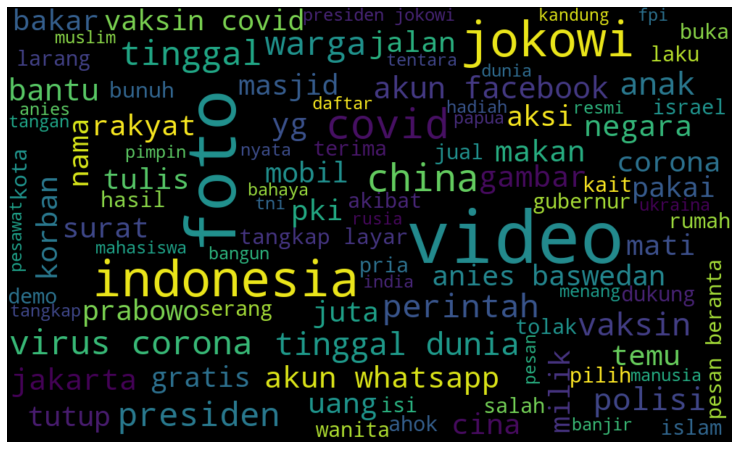

In [ ]:
headline_text = title_df["title"]
headline_text = " ".join(headline_text.to_list())
headline_text_wordcloud = WordCloud(width=1000,
                                    height=600,
                                    max_font_size=100,
                                    max_words=100,
                                    background_color="black").generate(headline_text)
plt.figure(figsize=(15,8))
plt.imshow(headline_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As we can see that after stemming and removing stopwords from data, some common word is "**video**", **"*foto*"** (photo), "**jokowi**" (Indonesia current president), etc as shown picture above.

Next we generate histogram of headline news word lengths.

In [ ]:
headline_visualization = title_df.copy()
headline_visualization["num_word"] = title_df["title"].apply(lambda x: len(str(x).split()))

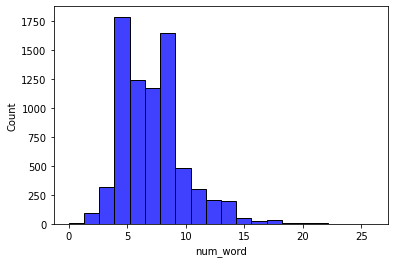

In [ ]:
sns.histplot(data=headline_visualization, x="num_word", bins=20, color="blue")

As shown from graph above, most of headline news have 5 to 10 words.

Bellow we look for 20 most common words that appear in news headline.

In [ ]:
headline_visualization["word_list"] = headline_visualization["title"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in headline_visualization["word_list"] for item in sublist])
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,video,829
1,foto,751
2,covid,450
3,jokowi,445
4,19,421
5,indonesia,381
6,akun,316
7,tinggal,272
8,vaksin,256
9,corona,256


Next we create tokenized data by applying `tokenizer` function.

In [ ]:
tokenized_data = title_df["title"].map(tokenizer)

Create dictionary from tokenized data.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from pprint import pprint
import gensim

id2word = Dictionary(tokenized_data)

[Back to Table of Contents](#chapter0)

# Modeling & Evaluation <a class="anchor" name="chapter5"></a>
---

## Latent Dirichlet Allocation (LDA)

LDA is a generative probabilistic model that tries to find groups of words that appears frequently together across different documents. These frequently appearing words represent our topics, assuming that each document is a mixture of different words.

Here we create a function that will return list of LDA model and it's corresponding coherence value.

In [ ]:
def model_and_evaluate(dictionary, corpus, texts, start = 1, stop = 11, step = 1):
  model_list = []
  coherence_val = []
  for i in range(start, stop, step):
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=i,
                            random_state=42,
                            chunksize=100,
                            passes=5,
                            alpha=.1,
                            eta=.1)
    model_list.append(lda_model)
    coherence_lda_model = CoherenceModel(model=lda_model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence="c_v")
    coherence_lda = coherence_lda_model.get_coherence()
    coherence_val.append(coherence_lda)
  print(f"Done.")
  return model_list, coherence_val

### Bag of Words Model

**Bag of words** or **BoW** is a model that will allow us to represent text as numerical feature vectors. Idea behind bag of words is quite simple, we create a vocabulary of unique tokens which we already did (`tokenized_data`) and then construct feature vector from each document that contain the counts of how often each words occurs in the particular document.

Here we create bag of words model from dictionary and see results of converting words from dictionary to numbers.

In [ ]:
bow_corpus = [id2word.doc2bow(text) for text in tokenized_data]
texts = tokenized_data
print(bow_corpus[:1][0][:5])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


Here we are using topics number starting from 2 topics until 18 topics with increase of 2 topics each step.

In [ ]:
start = 2
stop = 20
step = 2
bow_model_list, bow_coherence_val = model_and_evaluate(id2word, bow_corpus, texts, start, stop, step)

Done.


After fitting and coherence calculation done, next we plot coherence score for each *N*-number of topics.

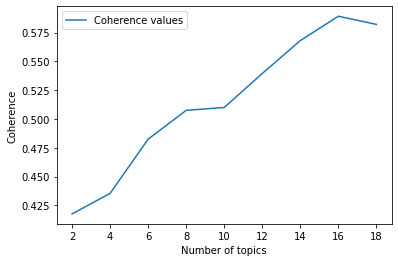

In [ ]:
x = range(start, stop, step)
plt.plot(x, bow_coherence_val, label=("Coherence values"))
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(loc="best")
plt.show()

As we can see from graph above, for this bag of words model that as the number of topic increases, the coherence score will also increases. Also it looks like that the coherence score can still improved by increasing number of topic. However, after fitting the model several times with different number of topics (with max. 50 topics), it is true that for this case the coherence score will also increase but that is also because there are repeated keywords in those topics. This is confirmed by plotting the result using pyLDAvis library bellow.

After training process is complete, the number of topics with the highest coherence value is 16 topics. Bellow is shown each topic with top 5 keywords of each topic.

In [ ]:
from collections import OrderedDict
index = bow_coherence_val.index(max(bow_coherence_val))
bow_best_model = bow_model_list[index]
print(f"Topic: {bow_best_model.num_topics}\nCoherence score: {max(bow_coherence_val)}")
my_dict = OrderedDict({f'Topic {i}': [token for token, score in bow_best_model.show_topic(i, topn=5)] for i in range(0, bow_best_model.num_topics)})
for k, v in my_dict.items():
  print(k, v)

Topic: 16
Coherence score: 0.5892426701862281
Topic 0 ['dukung', 'tni', 'air', 'bunuh', 'jual']
Topic 1 ['foto', 'masjid', 'milik', 'korban', 'ribu']
Topic 2 ['tulis', 'uang', 'kpu', 'juta', 'indonesia']
Topic 3 ['surat', 'pt', 'gratis', 'bank', 'indonesia']
Topic 4 ['al', 'kandung', 'kanker', 'suara', 'sebab']
Topic 5 ['video', 'indonesia', 'menang', 'akibat', 'sunting']
Topic 6 ['anak', 'bakar', 'foto', 'tangkap', 'jalan']
Topic 7 ['islam', 'jakarta', 'larang', 'acara', 'sandiaga']
Topic 8 ['muslim', 'pakai', 'rizieq', 'perintah', 'sakit']
Topic 9 ['jokowi', 'ahok', 'prabowo', 'pki', 'foto']
Topic 10 ['china', 'fpi', 'laku', 'palsu', 'pesawat']
Topic 11 ['cina', 'rakyat', 'tutup', 'shihab', 'kartu']
Topic 12 ['aksi', 'warga', 'temu', 'mati', 'rumah']
Topic 13 ['polisi', 'pesan', 'makan', 'anggota', 'papua']
Topic 14 ['virus', 'corona', 'tentara', 'gus', 'banjir']
Topic 15 ['tinggal', 'kota', 'dunia', 'akun', 'israel']


To visualize distribution of each topic better, here we are using pyLDAvis to plot all the topics. Each topic is represented by a circle, select one circle to see more details. <a class="anchor" name="bow"></a>

In [ ]:
import pyLDAvis
from pyLDAvis.gensim_models import prepare
lda_display = prepare(bow_best_model, bow_corpus, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Based on the above visualization, even though this is the best model based on the coherence score we can see that ther is a lot of topics that is overlapping each other. This is because as mentioned before, there are repeated keywords. There are only few topics that don't overlap each other like `Topic 6`, `Topic 10`, and `Topic 11`. `Topic 2` and `Topic 7` are almost on the same spot because number keyword in `Topic 2` which is *foto*(photo) is also top 3 keywords in `Topic 7`.

[Back to Table of Contents](#chapter0)

Create a function to get top *N* dominant sentence for each topics.

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts, num_top_title=5):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    # Group top 5 sentences under each topic
    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = sent_topics_df.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                grp.sort_values(['Perc_Contribution'], ascending=[0]).head(num_top_title)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    # Show
    return sent_topics_sorteddf_mallet

In [ ]:
def get_top_3(topic, topic_num):
  top_topic = topic.loc[topic["Topic_Num"] == topic_num]
  print(f"Topic {topic_num + 1}: {top_topic['Keywords'].iloc[0]}\nTop 3 headline title:")
  for i in top_topic["Text"]:
    print(f"Title: {i}")

Get top 3 most dominant title from each topics

In [ ]:
top_3_bow = format_topics_sentences(bow_best_model, bow_corpus, df["title"], 3)

#### Topic 6
---

Manually analyze topic 6

In [ ]:
get_top_3(top_3_bow, 5)

Topic 6: video, indonesia, menang, akibat, sunting, tv, serang, bom, hoax, komunis
Top 3 headline title:
Title:  Video Aksi Bunuh Diri di Roxy Mas Jakarta
Title:  Perdana Menteri Tiongkok Mengultimatum Indonesia
Title:  Ustaz Di Cianjur Dipersekusi dan Dibacok


Here we are going to analyze `Topic 6`. From the above results, it is shown that top 5 keywords is *'video'*, *'indonesia'*, *'menang'* (win), *'akibat'* (cause), and *'sunting'* (edit). Top 3 dominant title fort `Topic 6`:<br>
1. News title number 1 is about a suicide video that happen in Jakarta, so this fake news is in the correct topics.
2. News title number 2 is about Chinese Prime Minister gave an ultimatum to Indonesia, so it safe to say this title is in the correct topic. 
3. News title number 3 is about islamic religious leaders who were killed, the title has nothing to do with the top five keywords of topic 6. `Topic 8` or `Topic 9` is suitable topic for this one because these topics have keywords that related to religion.

#### Topic 10
---

Manually analyze topic 10

In [ ]:
get_top_3(top_3_bow, 9)

Topic 10: jokowi, ahok, prabowo, pki, foto, presiden, nama, anies, hasil, sandi
Top 3 headline title:
Title:  ANIES BASWEDAN KRITIS KUTUKAN AHOK BENAR BENAR JADI KENYATAAN
Title:  Pertemuan Referendum Raja dan Sultan Senusantara
Title:  Lelang Online oleh PT Pegadaian


As for `Topic 10`, the top 5 keywords is '*jokowi*' (current president of Indonesia), '*ahok*' (former governor of Jakarta), '*prabowo*' (current defense minister of Indonesia), '*pki*' (Indonesia Communist Party), and '*foto*' (photo). Based on the keywords, `Topic 10` is about politics related. We are going to analyze top 3 dominant fake news title for this topic to see if that title is related to the keywords generated by the model. <br>
1. Fake news title number 1 is about the current governor of Jakarta, Anies Baswedan, criticized about the *curse* former governor of Jakarta, Ahok, is become true. The model correctly puts the title of this one on the right topic.
2. Fake news title number 2 is about meeting of kings and sultans of Indonesia, which does not related to any keywords. 
3. Lastly, for fake news title number 3 is about online auction by one of the state-owned company.

### Topic 11
---

Manually analyze topic 11.

In [ ]:
get_top_3(top_3_bow, 10)

Topic 11: china, fpi, laku, palsu, pesawat, isi, video, foto, wanita, kampanye
Top 3 headline title:
Title:  Akun Facebook Wakil Wali Kota Semarang Heveanita Gunaryanti
Title:  Akun WhatsApp Wakil Bupati Pringsewu Meminta Sejumlah Dana
Title:  Sepertinya berangkat sendiri biaya sendiri selebrasi sendiri tidak ada yang kasih bendera


`Topic 11` top 5 keywords are *'china'*, *'fpi'* (Islamic Defenders Front), *'laku'* (sold out), *'palsu'* (fake), and *'pesawat'* (plane). Top 3 dominant fake news title: <br>
1. News title number 1 is about Semarang city vice mayor facebook account which is not related to any keywords. 
2. As for news title number 2 is about whatsapp account of Pringsewu vice regent, this one is also not related to any keywords. 
3. News title number 3 is about some supporter that went somewhere with their own money.

[Back to Table of Contents](#chapter0)

### TF-IDF model
---

Next one is **Term Frequency-Inverse Document Frequency** or **TF-IDF**. When we analyzing text data, we often encounter words that occur accross multiple title. These frequently occurring words typically don't contain useful information. TF-IDF can be used to downweight these frequently occurring words in feature vectors.

Convert the Bag of Words corpus into TF-IDF corpus.

In [ ]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
tfidf_model_list, tfidf_coherence_val = model_and_evaluate(id2word, tfidf_corpus, texts, start, stop, step)

Done.


Plot the coherence score for each *N* number of topics.

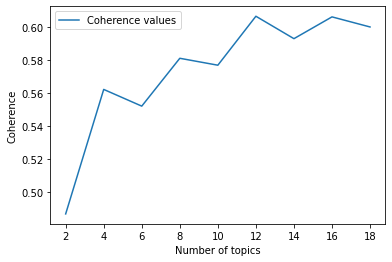

In [ ]:
x = range(start, stop, step)
plt.plot(x, tfidf_coherence_val, label=("Coherence values"))
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(loc="best")
plt.show()

Show topic number, coherence score, and each topics top 5 keywords.

In [ ]:
from collections import OrderedDict
tfidf_index = tfidf_coherence_val.index(max(tfidf_coherence_val))
tfidf_best_model = tfidf_model_list[tfidf_index]
print(f"Topic: {tfidf_best_model.num_topics}\nCoherence score: {max(tfidf_coherence_val)}")
tfidf_dict = OrderedDict({f'Topic {i}': [token for token, score in tfidf_best_model.show_topic(i, topn=5)] for i in range(0, tfidf_best_model.num_topics)})
for k, v in tfidf_dict.items():
  print(k, v)

Topic: 12
Coherence score: 0.606701113790169
Topic 0 ['edar', 'hasil', 'surat', 'sunting', 'demo']
Topic 1 ['bakar', 'jakarta', 'milik', 'kota', 'corona']
Topic 2 ['pesan', 'pakai', 'sebab', 'beranta', 'bank']
Topic 3 ['aksi', 'anak', 'temu', 'bencana', 'nomor']
Topic 4 ['papua', 'al', 'larang', 'menang', 'kanker']
Topic 5 ['china', 'indonesia', 'air', 'mati', 'bayi']
Topic 6 ['polisi', 'tni', 'jalan', 'bahaya', 'maaf']
Topic 7 ['ahok', 'tinggal', 'masjid', 'islam', 'uang']
Topic 8 ['warga', 'sandi', 'ktp', 'bangun', 'judul']
Topic 9 ['pki', 'prabowo', 'nama', 'jokowi', 'tulis']
Topic 10 ['dukung', 'muslim', 'makan', 'kandung', 'narkoba']
Topic 11 ['banjir', 'ancam', 'jembatan', 'biaya', 'rusuh']


By using TF-IDF corpus, LDA model generate less topics but with higher coherence score compared to same model that use bag of words corpus.

Visualize distribution of each topic. <a class="anchor" name="tfidf"></a>

In [ ]:
import pyLDAvis
from pyLDAvis.gensim_models import prepare
tfidf_lda_display = prepare(tfidf_best_model, tfidf_corpus, id2word, sort_topics = False)
pyLDAvis.display(tfidf_lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Even though model with TF-IDF corpus generate less topics with higher coherence score, it is shown from above visualisation that only 2 topics that are not overlapping with another topics, `Topic 8` and `Topic 10`. The same reason is also applied here because there are a lot of repeated keywords on these topics and these keywords are also in the top 10 to top 5 keywords. We can see this by choose one of the overlapping topics and see the distribution of each keywords.

[Back to Table of Contents](#chapter0)

Get top 3 dominant news title for each topics.

In [ ]:
top_3_tfidf = format_topics_sentences(tfidf_best_model, tfidf_corpus, df["title"], 3)

### Topic 6
---

Manually analyze topic 6.

In [ ]:
get_top_3(top_3_tfidf, 5)

Topic 6: china, indonesia, air, mati, bayi, jual, tv, buka, kristen, klaim
Top 3 headline title:
Title:  Kotoran Putih Pada Bayi Baru Lahir Dapat Dihilangkan Apabila Rajin Mengonsumsi Air Kelapa Selama Hamil
Title:  BSSN Pantau Aktivitas Telepon dan Media Sosial Masyarakat
Title:  Scan MRI Harus Dihindari Penerima Vaksin Covid 19


`Topic 6` top 5 keywords is *'china'*, *'indonesia'*, *'air'* (water), *'mati'* (dead), and *'bayi'* (baby). From top 3 most dominant title: <br> 
1. Fake news title number 1 is about newborn baby and efficacy of consumming coconut water during pregnancy. 
2. Fake news title number 2 is about some government agency that monitor community phone activities. 
3. Fake news title number 3 is about for people who have been vaccinated againts Covid-19 should avoid MRI scan.<br>

Only first title that related to the top 5 keywords.



### Topic 8
---

Manually analyze topic 8.

In [ ]:
get_top_3(top_3_tfidf, 7)

Topic 8: ahok, tinggal, masjid, islam, uang, korban, gratis, dunia, serta, hasut
Top 3 headline title:
Title:  Foto Masjid Meledak Saat Waktu Sholat Jumat Sebanyak 50 Jamaah Meninggal Dunia
Title:  Foto Perempuan Bela Diri Bunuh Pria yang Mau memperkosa Dirinya
Title:  Bupati Nduga Diculik TNI


`Topic 8` top 5 keywords is *'ahok'*, *'tinggal'* (stay), *'masjid'* (mosque), *'islam'*, and *'uang'* (money). As for keywords *'tinggal'*, this words could be about stay or about *'meninggal'* (dead) because the root form of *'meninggal'* is *'tinggal'* Top 3 news title:<br>
1. Fake news title number 1 is about photo of a mosque exploded and kills 50 people. This one is in the right topic.
2. Fake news title number 2 is about photo of a woman killing a man who wanted to rape her.
3. Fake news title number 3 is about Nduga regent being kidnapped by Indonesian army.<br>

After looking at the top 3 titles on this topic, only first title related to the keywords. The second title can be said to appropriate as it relates to murder which means someone dies (keyword: *'tinggal'*). As for third title, it is more about politic.


### Topic 10
---

Manually analyze topic 10.

In [ ]:
get_top_3(top_3_tfidf, 9)

Topic 10: pki, prabowo, nama, jokowi, tulis, cina, foto, fpi, presiden, israel
Top 3 headline title:
Title:  Anies Baswedan Mendapat Gelar Amirul Amanah dari Arab Saudi
Title:  Rektor ITB Bantah Berikan Dukungan kepada Satu Pasangan Cagub dan Cawagub Jabar
Title:  Ayah Jokowi Bernama Widjiatno Merupakan Anggota PKI Jokowi Asli PKI Tulen


`Topic 10` top 5 keywords is *'pki'* (Indonesia Communist Party), *'prabowo'* (current defense minister of Indonesia), *'nama'* (name), *'jokowi'* (current president of Indonesia), and *'tulis'* (write). Top 3 dominant fake news title:<br>
1. Fake news title number 1 is about governor of Jakarta gets honorary title from Saudi Arabia.
2. Fake news title number 2 is about chancellor of university in Bandung city denies support for a political partner.
3. And for fake news title number 3 is about current Indonesia president father is a member of Indonesian communist party (*'pki'*).<br>

After looking at top 5 keywords, `Topic 10` is mostly talking about politics. The first title is about governor of Jakarta, this is quite related because the former governor of Jakarta are Jokowi. Second title is about political support for candidate pairs of governor and deputy governor which is still talking about politics. Lastly, for the third title is discuss about Indonesian Communist Party (*'pki'*).

[Back to Table of Contents](#chapter0)